In [ ]:
from __future__ import print_function
import pandas as pd
import numpy as np
import datetime as dt
import quandl
import sys
from tqdm import tqdm
import seaborn as sns

In [ ]:
import mlfinlab

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mlfinlab.portfolio_optimization.herc import HierarchicalEqualRiskContribution


In [ ]:
stocks = {
  'materials': ['XOM', 'RDS-B', 'PTR', 'CVX', 'TOT', 'BP', 'BHP', 'SNP', 'SLB', 'BBL'],
  'consumer_goods': ['AAPL', 'PG', 'BUD', 'KO', 'PM', 'TM', 'PEP', 'UN', 'UL', 'MO'],
  'healthcare': ['JNJ', 'PFE', 'NVS', 'UNH', 'MRK', 'AMGN', 'MDT', 'ABBV', 'SNY', 'CELG'],
  'services': ['AMZN', 'BABA', 'WMT', 'CMCSA', 'HD', 'DIS', 'MCD', 'CHTR', 'UPS', 'PCLN'],
  'utilities': ['NEE', 'DUK', 'D', 'SO', 'NGG', 'AEP', 'PCG', 'EXC', 'SRE', 'PPL'],
  'cong': ['IEP', 'HRG', 'CODI', 'REX', 'SPLP', 'PICO', 'AGFS', 'GMRE'],
  'finance': ['BCH', 'BSAC', 'BRK-A', 'JPM', 'WFC', 'BAC', 'V', 'C', 'HSBC', 'MA'],
  'industrial_goods': ['GE', 'MMM', 'BA', 'HON', 'UTX', 'LMT', 'CAT', 'GD', 'DHR', 'ABB'],
  'tech': ['GOOG', 'MSFT', 'FB', 'T', 'CHL', 'ORCL', 'TSM', 'VZ', 'INTC', 'CSCO'] 
    }

In [ ]:
#sp500_URL = 'https://www.quandl.com/api/v3/datatables/WIKI/PRICES.csv?api_key=1X_UPAv5yAYqQzWt8U-L'
#sp500_scrapped = pd.read_csv(sp500_URL) # using P a n d a s read_html function
#tickers = read(sp500_scrapped)


In [ ]:
#wiki_sp500 = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
#wiki_scrapped = pd.read_html(wiki_sp500)


In [ ]:
#wiki_scrapped[0].Symbol.unique().size

In [ ]:
#print(sp500_scrapped)

# Data 

In [ ]:
datadir='../data/'
assets=pd.read_csv(datadir+'SP500.txt', comment='#').set_index('Symbol')

QUANDL={
    ## Get a key (free) from quandl.com and copy it here
    'authtoken':"1X_UPAv5yAYqQzWt8U-L",
    'start_date':dt.date(2007, 1, 1),
    'end_date':dt.date(2020, 11, 30)
}
RISK_FREE_SYMBOL = "USDOLLAR"
data={}

In [ ]:
assets.head(5)

#### Download loop

If it stops because of Quandl error codes 503 or 504, try re-running it (it won't download data already downloaded). If Quandl complains about the speed of requests, try adding sleep time.

In [ ]:
# download assets' data

def store_data(data,ticker):
    data['Ticker'] = ticker
    data = data.reset_index()
    data = data.set_index(['Date','Ticker'])
    return data

list_of_dataframes = []
from time import sleep

for ticker in tqdm(assets.index):
    if ticker in data:
        continue
    #print('downloading %s from %s to %s' %(ticker, QUANDL['start_date'], QUANDL['end_date']))
    try:
        data = quandl.get(assets.Quandlcode[ticker], **QUANDL)
        list_of_dataframes.append(store_data(data,ticker))
        #sleep(0.1)
    except quandl.NotFoundError:
        print('\tInvalid asset code')
data = pd.concat(list_of_dataframes)

In [215]:
data.head(5)

,,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,Value
Date,Ticker,,,,,,,,,,,,,
2007-01-03,MMM,77.53,78.85,77.38,78.26,3781500.0,0.0,1.0,58.652119,59.650711,58.538643,59.204371,3781500.0,NaN
2007-01-04,MMM,78.40,78.41,77.45,77.95,2968400.0,0.0,1.0,59.310282,59.317847,58.591598,58.969853,2968400.0,NaN
2007-01-05,MMM,77.89,77.90,77.01,77.42,2765200.0,0.0,1.0,58.924462,58.932027,58.258735,58.568903,2765200.0,NaN
2007-01-08,MMM,77.19,78.04,76.97,77.59,2434500.0,0.0,1.0,58.394906,59.037939,58.228474,58.697510,2434500.0,NaN
2007-01-09,MMM,78.00,78.23,77.44,77.68,1896800.0,0.0,1.0,59.007678,59.181675,58.584033,58.765595,1896800.0,NaN


In [ ]:
data.tail(5)

In [ ]:
tickers = data.index.get_level_values('Ticker').unique()
keys = tickers.to_series().keys()
#set(keys)

In [ ]:
keys=[el for el in assets.index if not el in (set(assets.index)-set(keys))]

In [ ]:
#keys

In [ ]:
prices = data['Adj. Close']
open_prices = data['Open']
close_prices = data['Close']
sigmas = np.abs(np.log(open_prices)-np.log(close_prices))
adj_volumes = data['Adj. Volume']

# Remove USD for now

In [ ]:
data_without_USD = data[data.index.get_level_values('Ticker') != RISK_FREE_SYMBOL]
data_without_USD = data_without_USD.drop(['Value'],axis=1)
data_without_USD.head(5)

In [ ]:
"""
assets_with_data_missing = data_without_USD.columns[data_without_USD.isnull().sum()>len(data_without_USD)*0.02]
if len(assets_with_data_missing):
    print('Assets %s have too many NaNs, removing them' % assets_with_data_missing)
data_without_USD = data_without_USD.loc[:,~data_without_USD.columns.isin(assets_with_data_missing)]
"""

In [ ]:
"""
#assets_with_data_missing = data_without_USD[data_without_USD.isnull().sum()>len(data_without_USD)*0.02]
rows_with_nan = [index for index, row in data_without_USD.iterrows() if row.isnull().any()]
print(rows_with_nan)
"""

In [ ]:
#data_without_USD.set_index(['Date','Ticker'],inplace=True)

# Delete all stocks where there are missing values

In [ ]:
nan_rows = data_without_USD[data_without_USD.isnull().T.any()]
idx1 = nan_rows.index
idx2 = data_without_USD.index.get_level_values('Ticker').unique()
idex = idx1.intersection(idx2)
data_without_USD = data_without_USD[~data_without_USD.index.get_level_values('Ticker').isin(idex)]


In [ ]:
data_without_USD.shape

# Find stock which has maximum data. Then only consider stocks which have atleast 90% of the maximum data to form portfolio

In [ ]:
ticker_level_data = data_without_USD.groupby(level=1)
count_of_assets = ticker_level_data.count()
count_greater_than = (count_of_assets >= count_of_assets.max()*0.9)
count_greater_than = count_greater_than.all(axis='columns')
count_of_assets = count_of_assets[count_greater_than]

In [ ]:
idx1 = count_of_assets.index
idx2 = data_without_USD.index.get_level_values('Ticker').unique()
idexxx = idx1.intersection(idx2)

In [ ]:
data_without_USD = data_without_USD[data_without_USD.index.get_level_values('Ticker').isin(idexxx)]
data_without_USD

In [ ]:
data_without_USD.shape

In [ ]:
data_without_USD = data_without_USD.rename(columns={"Adj. Close": "AdjustedClose"})


In [ ]:
"""
data_without_USD['Returns'] = df['Adj. Close'].pct_change()
tick1 = data_without_USD.index.get_level_values('Ticker').to_series()
tick2 = tick1.shift(1)
mask = tick1 != tick2
data_without_USD['Returns'][mask] = np.nan
"""

# Calculate Log - Returns

In [ ]:
tickers = data_without_USD.index.get_level_values('Ticker').unique()
noise = 0.0000000001
data_without_USD['Returns'] = np.nan 
data_without_USD['Returns'] = data_without_USD.groupby(['Ticker'])['AdjustedClose'].transform(lambda x: np.log(1+x.pct_change()))


In [ ]:
#data_without_USD['Returns_'] = data_without_USD.groupby(['Ticker'])['AdjustedClose','Adj. Open'].transform(lambda x,y: np.log(1+x.pct_change()))


# Calculate Mean and Standard Deviation of Log - Returns. Mean return is our return estimate.

In [ ]:
data_without_USD['Returns_hat'] = data_without_USD.groupby(['Ticker'])['Returns'].transform(lambda x: x.rolling(window=250,min_periods=250).mean().shift(1))


In [ ]:
data_without_USD['Returns_Standard_Deviation'] = data_without_USD.groupby(['Ticker'])['Returns'].transform(lambda x: x.rolling(window=250,min_periods=250).std().shift(1))


In [ ]:
returns_group = []
data_filtered = data_without_USD.reset_index()
for ticker in tqdm(idexxx):
    ddd = data_filtered[data_filtered['Ticker'] == ticker][['Date','Ticker','Returns']]
    #ddd_2 = data_filtered[data_filtered['Ticker'] == ticker][['Date','Ticker','AdjustedClose']]

    #print(ddd.tail(5))
    if len(ddd) == 0 :
        continue
    ddd = ddd.set_index(['Date'])
    ddd = ddd.pivot(index=ddd.index, columns='Ticker')['Returns']
    dicts = ddd.to_dict()
    ddd = pd.DataFrame.from_dict(dicts)
    returns_group.append(ddd)
rrr = pd.concat(returns_group,axis=1)


    #print(ddd.tail(5))

In [ ]:
rrr.cumsum()
plt.figure()
rrr.plot()

In [ ]:
"""
bitcoin_daily_price['Ticker'] = 'BTC'
"""

In [ ]:
"""
yyy = bitcoin_daily_price.pivot(index=bitcoin_daily_price.index,columns='Ticker')['Price']
dicts = yyy.to_dict()
yyy = pd.DataFrame.from_dict(dicts)
yyy
"""

In [ ]:
#rrr.index

In [ ]:
#bitcoin_daily_price.index

In [ ]:
"""
idx1 = rrr.index
idx2 = yyy.index

idex = idx1.intersection(idx2)
print(idex)
"""

In [ ]:
"""
rrrrrr = rrr[rrr.index.isin(idex)]
#yyy = yyy.iloc[idex]
#rrrrrr
yyy = yyy[yyy.index.isin(idex)]
yyy
"""

In [ ]:
"""returns_dataframe = pd.DataFrame(dict([(ticker, 
                        data_without_USD[data_without_USD.index.get_level_values('Ticker') == ticker]['Returns'])
                    for ticker in idx2]))"""

In [ ]:
data_without_USD

In [ ]:
#data_without_USD = data_without_USD[data_without_USD.index.get_level_values('Date').isin(idex)]

In [ ]:
data_without_USD

# To limit computational time for the presentation, consider only some stocks

In [ ]:
"""
stock_symbols = stocks.values()
stock_symbols
flat_list = [item for sublist in stock_symbols for item in sublist]

flat_list
flat_list = idexxx.intersection(flat_list)
flat_list
"""


In [ ]:
data_without_USD.reset_index(inplace=True)

In [ ]:
unique_tickers = data_without_USD['Ticker'].unique()
unique_tickers = unique_tickers[:80]
data_for_only_80_tickers = data_without_USD[data_without_USD['Ticker'].isin(unique_tickers)]
data_for_only_80_tickers

In [ ]:
data_filtered = data_for_only_80_tickers.reset_index()

returns_column = data_for_only_80_tickers['Returns']
returns_group = []
returns_group_2 = []
return_dict = {}
for ticker in tqdm(unique_tickers):
    ddd = data_filtered[data_filtered['Ticker'] == ticker][['Date','Ticker','Returns']]
    ddd_2 = data_filtered[data_filtered['Ticker'] == ticker][['Date','Ticker','AdjustedClose']]

    #print(ddd.tail(5))
    if len(ddd) == 0 :
        continue
    ddd = ddd.set_index(['Date'])
    ddd = ddd.pivot(index=ddd.index, columns='Ticker')['Returns']
    dicts = ddd.to_dict()
    ddd = pd.DataFrame.from_dict(dicts)
    #print(ddd.tail(5))
    returns_group.append(ddd)
    ddd_2 = ddd_2.set_index(['Date'])
    ddd_2 = ddd_2.pivot(index=ddd_2.index, columns='Ticker')['AdjustedClose']
    dicts = ddd_2.to_dict()
    ddd_2 = pd.DataFrame.from_dict(dicts)
    #print(ddd.tail(5))
    returns_group_2.append(ddd_2)
rrr = pd.concat(returns_group,axis=1)
data_of_flat_list = pd.concat(returns_group_2,axis=1)               


In [216]:
data_of_flat_list

,MMM,ABT,ACN,ATVI,ADBE,AAP,AES,AET,AFL,AMG,...,CAH,HSIC,KMX,CCL,CAT,CBG,CBS,CELG,CNP,CTL
2007-01-03,59.204371,17.582374,29.351687,7.843084,39.92,34.193163,16.859650,39.186880,35.589805,105.626318,...,37.304717,24.445,27.645,38.155721,44.813817,33.65,25.024250,28.600,10.320184,21.027625
2007-01-04,58.969853,17.916284,30.013270,7.907072,40.82,34.414198,16.867335,38.492337,35.197355,104.479073,...,37.269755,24.450,27.700,38.095810,44.696580,33.34,24.810435,29.020,10.338343,21.013199
2007-01-05,58.568903,17.916284,29.593729,7.861366,40.62,33.654991,16.383215,37.834348,35.243526,103.641086,...,37.252274,24.205,28.095,37.354413,44.125050,33.10,24.461996,28.790,10.162809,20.989157
2007-01-08,58.697510,17.980912,30.021338,7.856796,40.45,33.770314,16.152682,37.953152,35.266611,105.007803,...,37.380469,24.085,27.700,37.339436,44.176341,33.22,24.588701,28.650,10.065963,20.868944
2007-01-09,58.765595,18.031178,29.948725,7.852225,39.63,34.058620,15.491821,37.368273,35.397428,106.025359,...,37.293063,23.300,27.820,37.766301,44.418142,33.97,24.461996,27.425,10.108333,20.777582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,NaN,62.420000,162.030000,71.610000,226.85,115.240000,10.800000,170.010000,45.370000,192.260000,...,65.690000,65.670,61.510,67.060000,155.800000,NaN,50.870000,88.310,26.840000,16.350000
2018-03-22,NaN,60.930000,150.230000,69.760000,220.52,111.710000,10.820000,169.450000,44.370000,185.170000,...,63.860000,65.930,60.000,66.200000,146.900000,NaN,50.260000,86.910,26.730000,15.790000
2018-03-23,NaN,59.500000,147.350000,68.040000,215.02,110.840000,10.720000,168.110000,43.350000,180.920000,...,61.710000,64.590,59.360,64.410000,144.290000,NaN,49.270000,84.980,26.500000,15.520000
2018-03-26,NaN,61.070000,152.850000,70.080000,228.91,114.770000,10.840000,170.750000,44.090000,188.600000,...,62.100000,65.540,60.590,65.800000,149.190000,NaN,51.690000,87.170,26.840000,16.210000


In [ ]:
#ab = flat_list.append(pd.Index(['BTC']))


In [ ]:
#ab

In [ ]:
#frames = [data_of_flat_list,yyy]
#data_of_flat_list = pd.concat(frames,axis=1)
#data_of_flat_list

In [ ]:
"""
r_hat = rrr.rolling(window=250, min_periods=250).mean().shift(1).dropna()
#r_hat
#print(r_hat.columns)
"""

In [ ]:
#Sigma_hat = rrr.rolling(window=250, min_periods=250, closed='neither').corr().dropna()


In [ ]:
#Sigma_hat.tail(len(flat_list))

In [ ]:
"""
mask = np.triu(np.ones_like(Sigma_hat.tail(len(unique_tickers)), dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(Sigma_hat.tail(len(unique_tickers)), mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5})
"""

In [ ]:
#stocks_and_cryptos = data_of_flat_list.columns
#stocks_and_cryptos

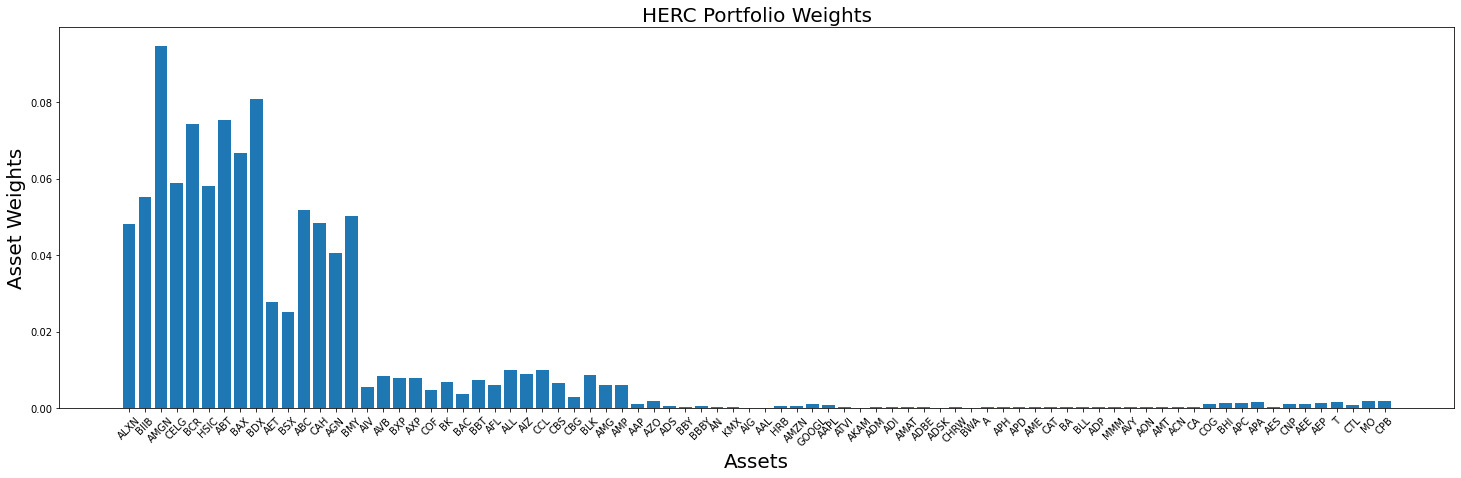

In [217]:
#data_of_flat_list = data_without_USD[data_without_USD.index.get_level_values('Ticker').isin(flat_list)]
herc = HierarchicalEqualRiskContribution()
herc.allocate(#asset_names=ab, 
              asset_prices=data_of_flat_list, 
              risk_measure="variance", 
              linkage="ward")
# plotting our optimal portfolio
herc_weights = herc.weights
y_pos = np.arange(len(herc_weights.columns))
plt.figure(figsize=(25,7))
plt.bar(list(herc_weights.columns), herc_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HERC Portfolio Weights', size=20)
plt.show()

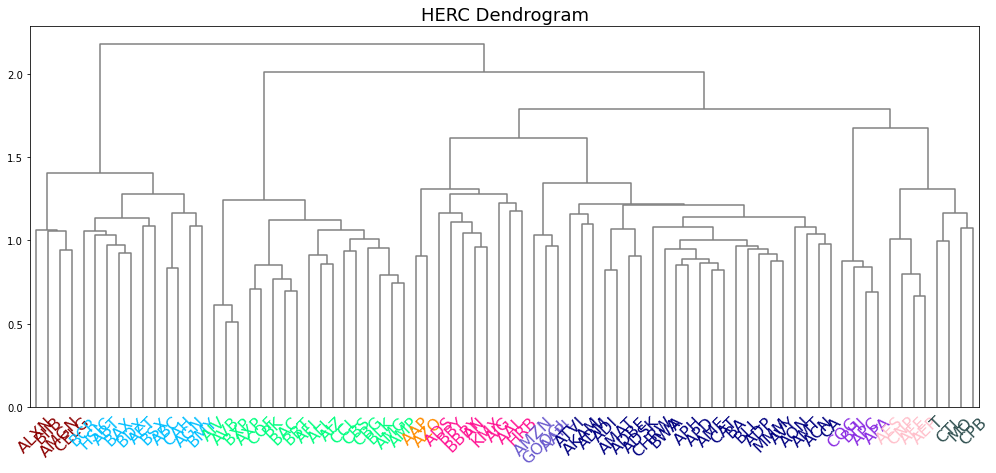

In [218]:
plt.figure(figsize=(17,7))
herc.plot_clusters(assets=data_of_flat_list.columns)
plt.title('HERC Dendrogram', size=18)
plt.xticks(rotation=45,fontsize=16)
plt.show()

In [ ]:
print("Optimal Number of Clusters: " + str(herc.optimal_num_clusters))


In [ ]:
#data_of_flat_list = data_without_USD[data_without_USD.index.get_level_values('Ticker').isin(flat_list)]
herc = HierarchicalEqualRiskContribution()
herc.allocate(asset_names=ab, 
              asset_prices=data_of_flat_list, 
              risk_measure="equal_weighting", 
              linkage="ward")
# plotting our optimal portfolio
herc_weights = herc.weights
y_pos = np.arange(len(herc_weights.columns))
plt.figure(figsize=(25,7))
plt.bar(list(herc_weights.columns), herc_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HERC Portfolio Weights', size=20)
plt.show()

In [ ]:
plt.figure(figsize=(17,7))
herc.plot_clusters(assets=data_of_flat_list.columns)
plt.title('HERC Dendrogram', size=18)
plt.xticks(rotation=45,fontsize=16)
plt.show()

In [ ]:
print("Optimal Number of Clusters: " + str(herc.optimal_num_clusters))


In [ ]:
#data_of_flat_list = data_without_USD[data_without_USD.index.get_level_values('Ticker').isin(flat_list)]
herc = HierarchicalEqualRiskContribution()
herc.allocate(asset_names=ab, 
              asset_prices=data_of_flat_list, 
              risk_measure="expected_shortfall", 
              linkage="ward")
# plotting our optimal portfolio
herc_weights = herc.weights
y_pos = np.arange(len(herc_weights.columns))
plt.figure(figsize=(25,7))
plt.bar(list(herc_weights.columns), herc_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HERC Portfolio Weights', size=20)
plt.show()

In [ ]:
plt.figure(figsize=(17,7))
herc.plot_clusters(assets=data_of_flat_list.columns)
plt.title('HERC Dendrogram', size=18)
plt.xticks(rotation=45,fontsize=16)
plt.show()

In [ ]:
print("Optimal Number of Clusters: " + str(herc.optimal_num_clusters))


In [ ]:
#data_of_flat_list = data_without_USD[data_without_USD.index.get_level_values('Ticker').isin(flat_list)]
herc = HierarchicalEqualRiskContribution()
herc.allocate(asset_names=ab, 
              asset_prices=data_of_flat_list, 
              risk_measure="expected_shortfall", 
              linkage="complete")
# plotting our optimal portfolio
herc_weights = herc.weights
y_pos = np.arange(len(herc_weights.columns))
plt.figure(figsize=(25,7))
plt.bar(list(herc_weights.columns), herc_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HERC Portfolio Weights', size=20)
plt.show()

In [ ]:
plt.figure(figsize=(17,7))
herc.plot_clusters(assets=data_of_flat_list.columns)
plt.title('HERC Dendrogram', size=18)
plt.xticks(rotation=45,fontsize=16)
plt.show()

In [ ]:
print("Optimal Number of Clusters: " + str(herc.optimal_num_clusters))


In [ ]:
#data_of_flat_list = data_without_USD[data_without_USD.index.get_level_values('Ticker').isin(flat_list)]
herc = HierarchicalEqualRiskContribution()
herc.allocate(asset_names=ab, 
              asset_prices=data_of_flat_list, 
              risk_measure="variance", 
              linkage="complete")
# plotting our optimal portfolio
herc_weights = herc.weights
y_pos = np.arange(len(herc_weights.columns))
plt.figure(figsize=(25,7))
plt.bar(list(herc_weights.columns), herc_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HERC Portfolio Weights', size=20)
plt.show()

In [ ]:
plt.figure(figsize=(17,7))
herc.plot_clusters(assets=data_of_flat_list.columns)
plt.title('HERC Dendrogram', size=18)
plt.xticks(rotation=45,fontsize=16)
plt.show()

In [ ]:
print("Optimal Number of Clusters: " + str(herc.optimal_num_clusters))


In [ ]:
#data_of_flat_list = data_without_USD[data_without_USD.index.get_level_values('Ticker').isin(flat_list)]
herc = HierarchicalEqualRiskContribution()
herc.allocate(asset_names=ab, 
              asset_prices=data_of_flat_list, 
              risk_measure="variance", 
              linkage="single")
# plotting our optimal portfolio
herc_weights = herc.weights
y_pos = np.arange(len(herc_weights.columns))
plt.figure(figsize=(25,7))
plt.bar(list(herc_weights.columns), herc_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HERC Portfolio Weights', size=20)
plt.show()

In [ ]:
plt.figure(figsize=(17,7))
herc.plot_clusters(assets=data_of_flat_list.columns)
plt.title('HERC Dendrogram', size=18)
plt.xticks(rotation=45,fontsize=16)
plt.show()

In [ ]:
print("Optimal Number of Clusters: " + str(herc.optimal_num_clusters))


In [ ]:
bitcoin_daily_price = pd.read_csv('/Users/ankitaggarwal/Downloads/Bitcoin Historical Data - Investing.com (1).csv')

In [ ]:
bitcoin_daily_price.shape

In [ ]:
bitcoin_daily_price['Date'] = pd.to_datetime(bitcoin_daily_price['Date'],dayfirst=False,yearfirst=False)
bitcoin_daily_price['Date']

In [ ]:
nan_rows = bitcoin_daily_price[bitcoin_daily_price.isnull().T.any()]
idx1 = nan_rows.index
nan_rows
#idx2 = bitcoin_daily_price.index.get_level_values('Ticker').unique()
#idex = idx1.intersection(idx2)
#data_without_USD = data_without_USD[~data_without_USD.index.get_level_values('Ticker').isin(idex)]

In [ ]:
#bitcoin_daily_price['Returns'] = np.nan
bitcoin_daily_price = bitcoin_daily_price.sort_values(by='Date')
bitcoin_daily_price['Price'] = bitcoin_daily_price['Price'].replace(',','', regex=True)
bitcoin_daily_price['Price'] = bitcoin_daily_price['Price'].astype(float)
bitcoin_daily_price['Returns'] = bitcoin_daily_price['Price'].transform(lambda x: np.log(1+x.pct_change()))
bitcoin_daily_price

In [ ]:
bitcoin_daily_price.head(5)

In [ ]:
bitcoin_daily_price['Returns_hat'] = bitcoin_daily_price['Returns'].transform(lambda x: x.rolling(window=250,min_periods=250).mean().shift(1))


In [ ]:
bitcoin_daily_price['Returns_Standard_Deviation'] = bitcoin_daily_price['Returns'].transform(lambda x: x.rolling(window=250,min_periods=250).std().shift(1))


In [ ]:
bitcoin_daily_price = bitcoin_daily_price.set_index('Date')

In [ ]:
btc_returns = bitcoin_daily_price['Returns'].cumsum()
plt.figure()
btc_returns.plot()

In [ ]:
out_of_sample = pd.read_csv('/Users/ankitaggarwal/Documents/AMS 691.03 ML in QF/ML in QF Project/data/Stocks_Test_data.csv')


In [ ]:
train_dataset = pd.read_csv('/Users/ankitaggarwal/Documents/AMS 691.03 ML in QF/ML in QF Project/data/Stocks_Train_data.csv')
validation_dataset = pd.read_csv('/Users/ankitaggarwal/Documents/AMS 691.03 ML in QF/ML in QF Project/data/Stocks_Validation_data.csv')


In [209]:
def returns_pivot(dataset,unique_tickers):
    data_filtered = train_dataset.reset_index()

    returns_column = train_dataset['Returns_from_adjusted_closed_to_adjusted_closed']
    returns_group = []
    returns_group_2 = []
    return_dict = {}
    for ticker in tqdm(unique_tickers):
        ddd = data_filtered[data_filtered['Ticker'] == ticker][['Date','Ticker','Returns_from_adjusted_closed_to_adjusted_closed']]
        ddd_2 = data_filtered[data_filtered['Ticker'] == ticker][['Date','Ticker','AdjustedClose']]
        ddd = ddd[:550]
        ddd_2 = ddd_2[:550]
        #print(ddd.tail(5))
        if len(ddd) == 0 :
            continue
        ddd = ddd.set_index(['Date'])
        ddd = ddd.pivot(index=ddd.index, columns='Ticker')['Returns_from_adjusted_closed_to_adjusted_closed']
        dicts = ddd.to_dict()
        ddd = pd.DataFrame.from_dict(dicts)
        #print(ddd.tail(5))
        returns_group.append(ddd)
        ddd_2 = ddd_2.set_index(['Date'])
        ddd_2 = ddd_2.pivot(index=ddd_2.index, columns='Ticker')['AdjustedClose']
        dicts = ddd_2.to_dict()
        ddd_2 = pd.DataFrame.from_dict(dicts)
        #print(ddd.tail(5))
        returns_group_2.append(ddd_2)
    rrr = pd.concat(returns_group,axis=1)
    data_of_flat_list = pd.concat(returns_group_2,axis=1) 
    print(data_of_flat_list.index)
    return data_of_flat_list


In [210]:
data_in_sample = returns_pivot(train_dataset,unique_tickers)

100%|██████████| 80/80 [00:05<00:00, 13.44it/s]

Index(['2007-06-14', '2007-06-15', '2007-06-18', '2007-06-19', '2007-06-20',
       '2007-06-21', '2007-06-22', '2007-06-25', '2007-06-26', '2007-06-27',
       ...
       '2009-08-05', '2009-08-06', '2009-08-07', '2009-08-10', '2009-08-11',
       '2009-08-12', '2009-08-13', '2009-08-14', '2009-08-17', '2009-08-18'],
      dtype='object', length=550)


In [211]:
data_in_sample.index = pd.to_datetime(data_in_sample.index)


In [212]:
#data_in_sample.index 

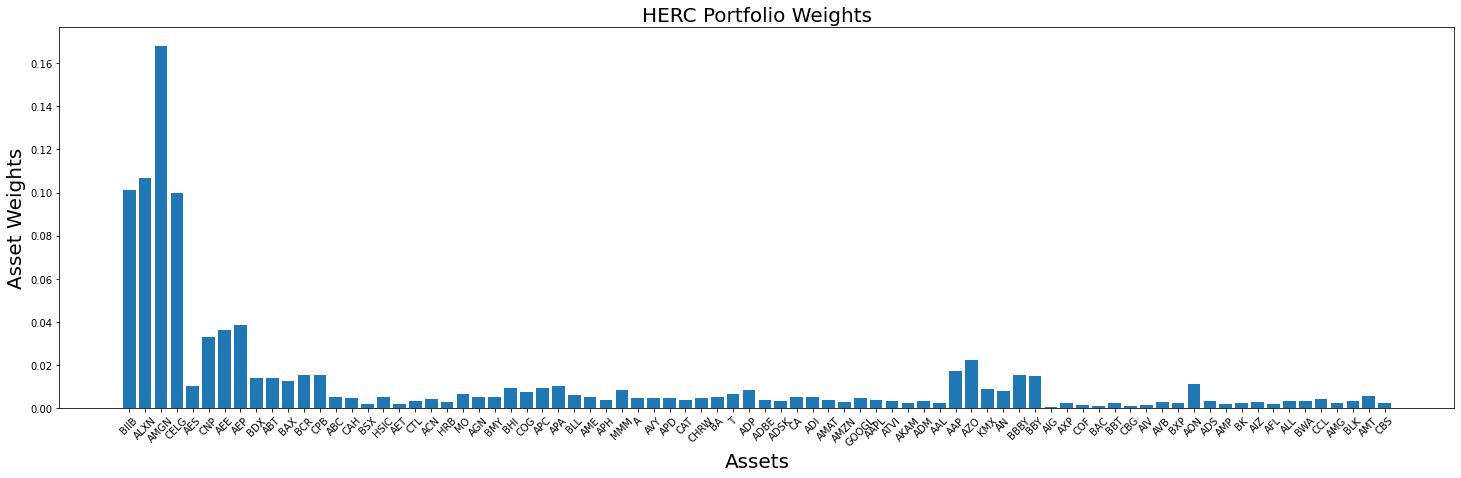

In [213]:
#data_of_flat_list = data_without_USD[data_without_USD.index.get_level_values('Ticker').isin(flat_list)]
herc = HierarchicalEqualRiskContribution()
herc.allocate(#asset_names=ab, 
              asset_prices=data_in_sample, 
              risk_measure="variance", 
              linkage="ward")
# plotting our optimal portfolio
herc_weights = herc.weights
y_pos = np.arange(len(herc_weights.columns))
plt.figure(figsize=(25,7))
plt.bar(list(herc_weights.columns), herc_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HERC Portfolio Weights', size=20)
plt.show()

In [214]:
herc_weights_2 = herc_weights.copy()

In [ ]:
#out_of_sample

In [141]:
unique_tickers = out_of_sample['Ticker'].unique()
unique_tickers = unique_tickers[:80]
out_of_sampleonly_80_tickers = out_of_sample[out_of_sample['Ticker'].isin(unique_tickers)]
out_of_sampleonly_80_tickers

,Date,Ticker,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,AdjustedClose,Adj. Volume,Returns_from_adjusted_closed_to_adjusted_closed
0,2015-03-20,MMM,166.09,167.134,165.39,166.49,4371778.0,0.0,1.0,155.713035,156.691808,155.056770,156.088044,4371778.0,NaN
1,2015-03-23,MMM,166.83,166.905,165.83,166.13,2155702.0,0.0,1.0,156.406802,156.477116,155.469280,155.750536,2155702.0,-0.002165
2,2015-03-24,MMM,165.58,167.650,165.53,166.32,2090967.0,0.0,1.0,155.234899,157.175570,155.188023,155.928666,2090967.0,0.001143
3,2015-03-25,MMM,166.24,166.520,162.66,162.70,2540422.0,0.0,1.0,155.853664,156.116170,152.497335,152.534836,2540422.0,-0.022006
4,2015-03-26,MMM,162.00,163.370,161.21,162.59,2050735.0,0.0,1.0,151.878570,153.162976,151.137928,152.431708,2050735.0,-0.000676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39035,2017-02-17,CTL,24.24,24.290,24.10,24.28,5122976.0,0.0,1.0,22.603761,22.650385,22.473211,22.641060,5122976.0,0.000000
39036,2017-02-21,CTL,24.30,24.710,24.29,24.67,6843331.0,0.0,1.0,22.659710,23.042035,22.650385,23.004735,6843331.0,0.015935
39037,2017-02-22,CTL,24.74,24.930,24.64,24.83,6431600.0,0.0,1.0,23.070010,23.247184,22.976760,23.153935,6431600.0,0.006465
39038,2017-02-23,CTL,24.89,24.970,24.56,24.71,6597988.0,0.0,1.0,23.209884,23.284484,22.902160,23.042035,6597988.0,-0.004845


In [167]:
list_of_out_of_sample_mean_returns = []
for ticker in tqdm(unique_tickers):
    out_of_sample_ticker = out_of_sample[out_of_sample['Ticker'] == ticker]
    mean_return = out_of_sample_ticker['Returns_from_adjusted_closed_to_adjusted_closed'].mean()
    #print(mean_return,ticker)
    weighted_mean_return = mean_return*herc_weights[ticker].values[0]
    dict_return = {'Ticker':ticker,'Mean_Return':mean_return,'Weighted_Mean_Return':weighted_mean_return} 
    list_of_out_of_sample_mean_returns.append(dict_return)#,columns=ticker
list_of_out_of_sample_mean_returns_dataframe = pd.DataFrame(list_of_out_of_sample_mean_returns)

100%|██████████| 80/80 [00:00<00:00, 81.82it/s]


In [171]:
list_of_out_of_sample_mean_returns_dataframe

,Ticker,Mean_Return,Weighted_Mean_Return
0,MMM,0.000351,1.943302e-06
1,ABT,0.000018,3.699971e-07
2,ACN,0.000700,2.880693e-06
3,ATVI,0.001403,3.526277e-06
4,ADBE,0.000890,2.217996e-06
...,...,...,...
75,CBG,-0.000087,-5.847980e-08
76,CBS,0.000157,2.633182e-07
77,CELG,-0.000171,-2.736601e-06
78,CNP,0.000702,5.037335e-05


In [ ]:
list_of_dataframes = []
for ticker in tqdm(unique_tickers):
    out_of_sample_ticker = out_of_sample[out_of_sample['Ticker'] == ticker]
    out_of_sample_ticker_return = out_of_sample_ticker['Returns_from_adjusted_closed_to_adjusted_closed'] * herc_weights[ticker]
    print(out_of_sample_ticker_return)
    out_of_sample_ticker['Weighted_Returns_from_adjusted_closed_to_adjusted_closed'] = out_of_sample_ticker_return
    list_of_dataframes.append(out_of_sample_ticker)
print(pd.concat(list_of_dataframes,axis=0))

In [ ]:
out_of_sample_ticker

In [ ]:
#returns_group = pd.concat(returns_group)

In [ ]:
"""
r_hat = returns.rolling(window=250, min_periods=250).mean().shift(1).dropna()
Sigma_hat = returns.rolling(window=250, min_periods=250, closed='neither').cov().dropna()

r_hat.tail()
"""

In [ ]:
#correlation_matrix

In [ ]:
data_without_USD

In [ ]:
data_group_by_date_min = data_without_USD.groupby('Ticker').Date.agg(min_date = 'min')
#print(data_group_by_date_min)
data_group_by_date_max = data_without_USD.groupby('Ticker').Date.agg(max_date = 'max')
latest_start_time = data_group_by_date_min.min_date.max()
stock = data_group_by_date_min[data_group_by_date_min.min_date == latest_start_time]
print(stock.index)
earliest_end_time = data_group_by_date_max[data_group_by_date_max.index.isin(stock.index)]
print(earliest_end_time)
earliest_end_time = data_group_by_date_max.max_date.min()
print(latest_start_time,earliest_end_time)

In [ ]:
data_interval

In [ ]:
data_interval = data_without_USD[(data_without_USD.Date >= latest_start_time)]
data_interval = data_interval[(data_interval.Date <= earliest_end_time)]
min_count = data_interval.groupby('Ticker').Date.count().min()
#print(min_count)
tickers = data_interval.groupby('Ticker').Date.count() == min_count
#print(np.where(tickers == True)[0][0])
#print(tickers.index[np.where(tickers == True)[0][0]])
ticker_value = tickers.index[np.where(tickers == True)[0][0]]
print(ticker_value)
print(data_interval[data_interval.Ticker == ticker_value].Date.max())
#ds = data_interval[]
data_interval_2 = data_interval[(data_interval.Date <= data_interval[data_interval.Ticker == ticker_value].Date.max())]
print(data_interval_2.groupby('Ticker').Date.count().min())
print(data_interval_2.groupby('Ticker').Date.count().max())


In [ ]:
data_interval_2.set_index(['Date','Ticker'],inplace=True)

In [ ]:
#create some data with Names column
#data = pd.DataFrame({'Names': ['Joe', 'John', 'Jasper', 'Jez'] *4, 'Ob1' : np.random.rand(16), 'Ob2' : np.random.rand(16)})

#create unique list of names
UniqueTickers = data_interval_2.index.get_level_values('Ticker').unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueTickers}

for key in DataFrameDict.keys():
    DataFrameDict[key] = data_interval_2[:][data_interval_2.index.get_level_values('Ticker') == key]

In [ ]:
n = 80
train_dataset = []
validation_dataset = []
test_dataset = []
#df.head(int(len(df)*(n/100)))
for key in DataFrameDict.keys():
    dataframe = DataFrameDict[key]
    top_n_percent_rows = dataframe.head(int(len(dataframe)*(n/100)))
    bottom_hundred_minus_n_percent_rows = dataframe.tail(int(len(dataframe)*((100-n)/100)))
    test_dataset.append(bottom_hundred_minus_n_percent_rows)
    train_data = top_n_percent_rows.head(int(len(top_n_percent_rows)*0.7))
    #x_shaped = np.reshape(x, newshape=(-1, num_steps, num_features))
    validation_data = top_n_percent_rows.tail(int(len(top_n_percent_rows)*0.3))
    train_dataset.append(train_data)
    validation_dataset.append(validation_data)
                                              

In [ ]:
train_dataset = pd.concat(train_dataset)
validation_dataset = pd.concat(validation_dataset)
test_dataset = pd.concat(test_dataset)


In [ ]:
train_dataset = train_dataset.rename(columns={"Adj. Close": "AdjustedClose"})
validation_dataset = validation_dataset.rename(columns={"Adj. Close": "AdjustedClose"})
test_dataset = test_dataset.rename(columns={"Adj. Close": "AdjustedClose"})

In [ ]:
train_dataset['Returns_from_adjusted_closed_to_adjusted_closed'] = train_dataset.groupby(['Ticker'])['AdjustedClose'].transform(lambda x: np.log(1+x.pct_change()))
validation_dataset['Returns_from_adjusted_closed_to_adjusted_closed'] = validation_dataset.groupby(['Ticker'])['AdjustedClose'].transform(lambda x: np.log(1+x.pct_change()))
test_dataset['Returns_from_adjusted_closed_to_adjusted_closed'] = test_dataset.groupby(['Ticker'])['AdjustedClose'].transform(lambda x: np.log(1+x.pct_change()))


In [ ]:
train_data_set_CSV = train_dataset.to_csv('/Users/ankitaggarwal/Documents/AMS 691.03 ML in QF/ML in QF Project/data/Stocks_Train_data.csv')
validation_data_set_CSV = validation_dataset.to_csv('/Users/ankitaggarwal/Documents/AMS 691.03 ML in QF/ML in QF Project/data/Stocks_Validation_data.csv')
test_data_set_CSV = test_dataset.to_csv('/Users/ankitaggarwal/Documents/AMS 691.03 ML in QF/ML in QF Project/data/Stocks_Test_data.csv')

In [ ]:
train_dataset = pd.read_csv('/Users/ankitaggarwal/Documents/AMS 691.03 ML in QF/ML in QF Project/data/Stocks_Train_data.csv')
validation_dataset = pd.read_csv('/Users/ankitaggarwal/Documents/AMS 691.03 ML in QF/ML in QF Project/data/Stocks_Validation_data.csv')
test_dataset = pd.read_csv('/Users/ankitaggarwal/Documents/AMS 691.03 ML in QF/ML in QF Project/data/Stocks_Test_data.csv')


In [ ]:
print(train_dataset.tail(1))
print(validation_dataset.head(1))

In [ ]:
train_and_validation_dataset = pd.concat([train_dataset,validation_dataset])
train_and_validation_dataset

In [ ]:
train_and_validation_data_set_CSV = train_and_validation_dataset.to_csv('/Users/ankitaggarwal/Documents/AMS 691.03 ML in QF/ML in QF Project/data/Stocks_train_and_validation_data.csv')

In [ ]:
valid_data = validation_dataset.loc[validation_dataset['Returns_from_adjusted_closed_to_adjusted_closed'].notnull(),:]
valid_data.set_index(['Date','Ticker'],inplace=True)
valid_data['Returns_from_adjusted_closed_to_adjusted_closed']

In [ ]:
valid_data.reset_index(inplace=True)
unique_tickers = valid_data['Ticker'].unique()
unique_tickers = unique_tickers[:80]
mean_of_validation_results = []
for ticker in tqdm(unique_tickers):
    get_data = valid_data[valid_data['Ticker'] == ticker]
    mean_of_validation_results.append([get_data['Returns_from_adjusted_closed_to_adjusted_closed'].mean(),ticker])

In [ ]:
mean_of_validation_results

In [ ]:
ddd = train_dataset.set_index(['Date'])
ddd = train_dataset.pivot(index=ddd.index, columns='Ticker')['Returns_from_adjusted_closed_to_adjusted_closed']
len(ddd)

In [ ]:
ddd.head(5)

In [ ]:
first_index = ddd.iloc[1]

In [ ]:
first_index

In [ ]:
covariance_matrix = ddd.cov()

In [ ]:
"""
tickers = data_without_USD.index.get_level_values('Ticker').unique()
for ticker in tickers:
    #df = data_without_USD.loc[data_without_USD['Ticker'] == ticker,'Returns'] = 
    
    data_without_USD.loc[data_without_USD.index.get_level_values('Ticker') == ticker,'Returns'] = data_without_USD.\
    loc[data_without_USD.index.get_level_values('Ticker') == ticker,'Adj. Close'].pct_change().fillna(method='ffill').iloc[1:]
   

    data_without_USD.loc[data_without_USD.index.get_level_values('Ticker') == ticker,'Returns_hat'] = data_without_USD.\
    loc[data_without_USD.index.get_level_values('Ticker') == ticker,'Returns'].rolling(window=250,min_periods=250).mean().shift(1)
    
    data_without_USD.loc[data_without_USD.index.get_level_values('Ticker') == ticker,'Returns_Standard_Deviation'] = data_without_USD.\
    loc[data_without_USD.index.get_level_values('Ticker') == ticker,'Returns'].rolling(window=250,min_periods=250).std().shift(1)
    #data_without_USD.update(df)
"""   

In [ ]:
data_without_USD.tail(5)

In [ ]:
print(data_without_USD[['Returns','Returns_hat','Returns_Standard_Deviation']])


In [ ]:
Sigma_hat = returns.rolling(window=250, min_periods=250, closed='neither').cov().dropna()


In [ ]:
print(data_without_USD[['Returns','Returns_hat','Returns_Standard_Deviation']])


#### Computation 

#### Filtering 

In [ ]:
# filter NaNs - threshold at 2% missing values
bad_assets = prices.columns[prices.isnull().sum()>len(prices)*0.02]
if len(bad_assets):
    print('Assets %s have too many NaNs, removing them' % bad_assets)

prices = prices.loc[:,~prices.columns.isin(bad_assets)]
sigmas = sigmas.loc[:,~sigmas.columns.isin(bad_assets)]
volumes = volumes.loc[:,~volumes.columns.isin(bad_assets)]

nassets=prices.shape[1]

# days on which many assets have missing values
bad_days1=sigmas.index[sigmas.isnull().sum(1) > nassets*.9]
bad_days2=prices.index[prices.isnull().sum(1) > nassets*.9]
bad_days3=volumes.index[volumes.isnull().sum(1) > nassets*.9]
bad_days=pd.Index(set(bad_days1).union(set(bad_days2)).union(set(bad_days3))).sort_values()
print ("Removing these days from dataset:")
print(pd.DataFrame({'nan price':prices.isnull().sum(1)[bad_days],
                    'nan volumes':volumes.isnull().sum(1)[bad_days],
                    'nan sigmas':sigmas.isnull().sum(1)[bad_days]}))

prices=prices.loc[~prices.index.isin(bad_days)]
sigmas=sigmas.loc[~sigmas.index.isin(bad_days)]
volumes=volumes.loc[~volumes.index.isin(bad_days)]

# extra filtering
print(pd.DataFrame({'remaining nan price':prices.isnull().sum(),
                    'remaining nan volumes':volumes.isnull().sum(),
                    'remaining nan sigmas':sigmas.isnull().sum()}))
prices=prices.fillna(method='ffill')
sigmas=sigmas.fillna(method='ffill')
volumes=volumes.fillna(method='ffill')
print(pd.DataFrame({'remaining nan price':prices.isnull().sum(),
                    'remaining nan volumes':volumes.isnull().sum(),
                    'remaining nan sigmas':sigmas.isnull().sum()}))

In [ ]:
keys=[el for el in assets.index if not el in (set(assets.index)-set(data.keys()))]

def select_first_valid_column(df, columns):
    for column in columns:
        if column in df.columns:
            return df[column]
        
# extract prices
prices=pd.DataFrame.from_records([(k,select_first_valid_column(data[k], ["Adj. Close", "Close", "Value"])) 
                                for k in keys])



In [ ]:
#compute sigmas
#open_price=pd.DataFrame.from_records([(k,select_first_valid_column(data[k], ["Open"])) for k in keys])
#close_price=pd.DataFrame.from_records([(k,select_first_valid_column(data[k], ["Close"])) for k in keys])


In [ ]:
sigmas = np.abs(np.log(open_price.values.astype(float))-np.log(close_price.values.astype(float)))

In [ ]:
# extract volumes
volumes=pd.DataFrame.from_records([(k,select_first_valid_column(data[k], ["Adj. Volume", "Volume"])) for k in keys])

# fix risk free
prices[RISK_FREE_SYMBOL]=10000*(1 + prices[RISK_FREE_SYMBOL]/(100*250)).cumprod()

#### Save 

In [ ]:
# make volumes in dollars
volumes = volumes*prices

# compute returns
returns = (prices.diff()/prices.shift(1)).fillna(method='ffill').ix[1:]

bad_assets = returns.columns[((-.5>returns).sum()>0)|((returns > 2.).sum()>0)]
if len(bad_assets):
    print('Assets %s have dubious returns, removed' % bad_assets)
    
prices = prices.loc[:,~prices.columns.isin(bad_assets)]
sigmas = sigmas.loc[:,~sigmas.columns.isin(bad_assets)]
volumes = volumes.loc[:,~volumes.columns.isin(bad_assets)]
returns = returns.loc[:,~returns.columns.isin(bad_assets)]

# remove USDOLLAR
prices = prices.iloc[:,:-1]
sigmas = sigmas.iloc[:,:-1]
volumes = volumes.iloc[:,:-1]


# save data
prices.to_csv(datadir+'prices.csv.gz', compression='gzip', float_format='%.3f')
volumes.to_csv(datadir+'volumes.csv.gz', compression='gzip', float_format='%d')
returns.to_csv(datadir+'returns.csv.gz', compression='gzip', float_format='%.3e')
sigmas.to_csv(datadir+'sigmas.csv.gz', compression='gzip', float_format='%.3e')

# Estimates 

In [ ]:
print("typical variance of returns: %g"%returns.var().mean())

In [ ]:
sigma2_n=0.02
sigma2_r=0.0005

np.random.seed(0)
noise=pd.DataFrame(index=returns.index, columns=returns.columns, 
                   data=np.sqrt(sigma2_n)*np.random.randn(*returns.values.shape))
return_estimate= (returns + noise)*sigma2_r/(sigma2_r+sigma2_n)
return_estimate.USDOLLAR = returns.USDOLLAR

return_estimate.to_csv(datadir+'return_estimate.csv.gz', compression='gzip', float_format='%.3e')

In [ ]:
agree_on_sign=np.sign(returns.ix[:,:-1]) == np.sign(return_estimate.ix[:,:-1])
print("Return predictions have the right sign %.1f%% of the times"%
      (100*agree_on_sign.sum().sum()/(agree_on_sign.shape[0]*(agree_on_sign.shape[1]-1))))

In [ ]:
volume_estimate=volumes.rolling(window=10, center=False).mean().dropna()
volume_estimate.to_csv(datadir+'volume_estimate.csv.gz', compression='gzip', float_format='%d')
sigmas_estimate = sigmas.rolling(window=10, center=False).mean().dropna()
sigmas_estimate.to_csv(datadir+'sigma_estimate.csv.gz', compression='gzip', float_format='%.3e')

# Risk model 

In [ ]:
start_t="2012-01-01"
end_t="2016-12-31"

first_days_month=\
    pd.date_range(start=returns.index[next(i for (i,el) in enumerate(returns.index >= start_t) if el)-1],
                                 end=returns.index[-1], freq='MS')

k=15
exposures, factor_sigma, idyos = {}, {},{}
for day in first_days_month:
    used_returns = returns.loc[(returns.index < day)&
                        (returns.index >= day-pd.Timedelta("730 days"))]
    second_moment=used_returns.values.T@used_returns.values/used_returns.values.shape[0]
    eival,eivec=np.linalg.eigh(second_moment)
    factor_sigma[day]=np.diag(eival[-k:])
    exposures[day]=pd.DataFrame(data=eivec[:,-k:],index=returns.columns)
    idyos[day]=pd.Series(data=np.diag(eivec[:,:-k]@np.diag(eival[:-k])@eivec[:,:-k].T),index=returns.columns)
    
pd.Panel(exposures).swapaxes(1,2).to_hdf(datadir+'risk_model.h5', 'exposures')
pd.DataFrame(idyos).T.to_hdf(datadir+'risk_model.h5', 'idyos')
pd.Panel(factor_sigma).to_hdf(datadir+'risk_model.h5', 'factor_sigma')

# load with
# store = pd.HDFStore('risk_model.h5')
# store.exposures, etc.